In [92]:
#%matplotlib notebook
import zipfile
import gmaps
import gmaps.datasets
import os
import pandas as pd
import kaggle
import requests
import json
from census import Census
import matplotlib.pyplot as plt
import requests
import json
from pygeocoder import Geocoder, GeocoderError
from pyzipcode import ZipCodeDatabase
import scipy.stats as stats

# Census API Key
from config import census_key, gkey
c = Census(census_key, year=2013)
gmaps.configure(api_key=gkey)

#url for google geocode api
basegeo_url = "https://maps.googleapis.com/maps/api/geocode/json"

In [2]:
#Retrive the dataset from kaggle and move to Resources folder
os.system('kaggle datasets download -d starbucks/store-locations' )
os.system('mv -f ./store-locations.zip ./Resources/')

0

In [3]:
#Unzip the dataset downloaded from kaggle
zip_file = os.path.join('Resources', 'store-locations.zip' )
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('Resources')
zip_ref.close()

In [4]:
#Read starbucks file into a dataframe
str_file = os.path.join('Resources','directory.csv')
str_df = pd.read_csv(str_file)
str_df.head(5)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [5]:
#Create a dataframe for starbucks in USA 
str_df_us = str_df.loc[str_df['Country'] == 'US']
str_df_us.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
11964,Starbucks,3513-125945,Safeway-Anchorage #1809,Licensed,5600 Debarr Rd Ste 9,Anchorage,AK,US,995042300,907-339-0900,GMT-09:00 America/Anchorage,-149.78,61.21
11965,Starbucks,74352-84449,Safeway-Anchorage #2628,Licensed,1725 Abbott Rd,Anchorage,AK,US,995073444,907-339-2800,GMT-09:00 America/Anchorage,-149.84,61.14
11966,Starbucks,12449-152385,Safeway - Anchorage #1813,Licensed,1501 Huffman Rd,Anchorage,AK,US,995153596,907-339-1300,GMT-09:00 America/Anchorage,-149.85,61.11
11967,Starbucks,24936-233524,100th & C St - Anchorage,Company Owned,"320 W. 100th Ave, 100, Southgate Shopping Ctr ...",Anchorage,AK,US,99515,(907) 227-9631,GMT-09:00 America/Anchorage,-149.89,61.13
11968,Starbucks,8973-85630,Old Seward & Diamond,Company Owned,1005 E Dimond Blvd,Anchorage,AK,US,995152050,907-344-4160,GMT-09:00 America/Anchorage,-149.86,61.14


In [10]:
#Remove this code - fill in Postcode for 1 record that is missing Postcode.
#str_df_us['Postcode'].fillna(44406, inplace=True)

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [6]:
#Add a new column - Zipcode & populate it from Postcode
str_df_us['Zipcode'] = '00000'
str_df_us.Zipcode = str_df_us.Postcode.astype(str).str[0:5]
str_df_us.count()

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Brand             13608
Store Number      13608
Store Name        13608
Ownership Type    13608
Street Address    13608
City              13608
State/Province    13608
Country           13608
Postcode          13607
Phone Number      13122
Timezone          13608
Longitude         13608
Latitude          13608
Zipcode           13608
dtype: int64

In [7]:
#Get Zipcodes from Google Geocode API for records without a Poscode.
for index, row in str_df_us.iterrows():
    if (  str(   (row)['Postcode']   )  == 'nan'  ):
        #print(index, row)
        address = row['Street Address'] + ' ' + row['State/Province'] + ' ' + row['Country']
        params = { 'address' : address  , 'key' : gkey }
        #print(address)
        response = requests.get(basegeo_url, params=params).json()
        pc = response['results'][0]['address_components'][7]['short_name']
        str_df_us.loc[str_df_us['Store Number'] == row['Store Number'], 'Zipcode'] = pc

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
#Get census data
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B23025_002E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_002E": "Employment Labor Force",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Employment Labor Force", "Poverty Rate"]]

census_pd.head()

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Employment Labor Force,Poverty Rate
0,08518,5217.0,41.5,74286.0,33963.0,170.0,3220.0,3.258578
1,08520,27468.0,37.4,90293.0,37175.0,1834.0,16187.0,6.676860
2,08525,4782.0,47.1,118656.0,59848.0,43.0,3004.0,0.899205
3,08527,54867.0,42.2,88588.0,37021.0,2191.0,29204.0,3.993293
4,08528,245.0,48.5,58676.0,49117.0,0.0,130.0,0.000000


In [9]:
#Merge Starbucks and Census dataframes on Zipcode
data_df = census_pd.merge(str_df_us, how = 'outer', on="Zipcode")
data_df.head()

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Employment Labor Force,Poverty Rate,Brand,Store Number,...,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,08518,5217.0,41.5,74286.0,33963.0,170.0,3220.0,3.258578,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08520,27468.0,37.4,90293.0,37175.0,1834.0,16187.0,6.676860,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,08525,4782.0,47.1,118656.0,59848.0,43.0,3004.0,0.899205,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08527,54867.0,42.2,88588.0,37021.0,2191.0,29204.0,3.993293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,08528,245.0,48.5,58676.0,49117.0,0.0,130.0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Get lat, long for Starbucks stores
locations = str_df_us[["Latitude", "Longitude"]].astype(float)

In [154]:
#Plot the lat long on Google map
fig = gmaps.figure()

#starbucks_layer = gmaps.symbol_layer(locations, fill_color='green', stroke_color='green', scale=1)
#fig.add_layer(starbucks_layer)
#fig


Figure(layout=FigureLayout(height='420px'))

In [11]:
#Group the starbucks dataset by State
str_grp = str_df_us.groupby(by = 'State/Province')
str_grp_cnt = str_grp['Store Number'].count()

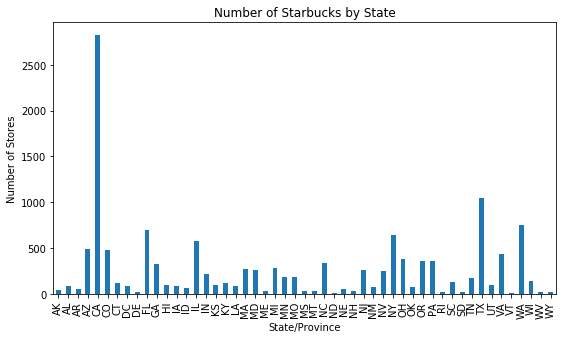

In [12]:
#Bar chart of Number of Stores by State
str_grp_cnt.plot(kind="bar", title = "Number of Starbucks by State", figsize = (9,5))
plt.ylabel("Number of Stores")
plt.savefig('Starbucks_Stores_State_Count')

In [13]:
#Read in the state vs. Lat long file
state_ll = os.path.join('Resources', 'state_lat_long.csv')
state_ll_df = pd.read_csv(state_ll)

In [14]:
#Merge the starbucks and State Lat Long dataframes
str_ll_new = str_df_us.merge(state_ll_df, how = 'inner', on="State/Province")

In [15]:
#Group the merged dataframe by State
str_ll_new_grp = str_ll_new.groupby(by = 'State/Province')
lat = str_ll_new_grp['Latitude_y'].min()
lng = str_ll_new_grp['Longitude_y'].min()

In [16]:
#Create a dataframe with State Lat Long, Number of stores
str_last_df = pd.DataFrame({ 'Lat' : lat, 'Lng' : lng, 'count' : str_grp['Store Number'].count() })

In [91]:
#Draw a heat map of Starbucks by State
#df = gmaps.datasets.load_dataset_as_df(str_last_df)
# dataframe with columns ('latitude', 'longitude', 'magnitude')
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer( str_last_df[['Lat', 'Lng']], dissipating = False, weights=str_last_df['count'], max_intensity=100, point_radius=3.0 )
heatmap_layer.dissipating = False
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 1
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [17]:
#Replacing all sister concerns of Starbucks ('Teavana', 'Evolution Fresh','Coffee House Holdings') to Starbucks

data_df['Brand'] = data_df['Brand'].str.strip().replace("Teavana","Starbucks")
data_df['Brand'] = data_df['Brand'].str.strip().replace("Evolution Fresh","Starbucks")
data_df['Brand'] = data_df['Brand'].str.strip().replace("Coffee House Holdings","Starbucks")

type_df = data_df.loc[data_df["Brand"] == "Starbucks",:]

Mean age of all Starbucks locatin in US is 37.473168936326836 and Standard Deviation is 6.830306956725909


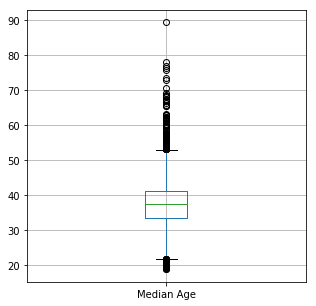

In [18]:
# Median age of Starbucks Zip code

grouped_combined_df = type_df.groupby(["Zipcode"])

grouped_combined_df_age = grouped_combined_df['Median Age'].mean()

grouped_combined_df_brand = grouped_combined_df['Brand'].first()

grouped_df_new= pd.DataFrame({"Brand": grouped_combined_df_brand, "Median Age":grouped_combined_df_age })

type_final_df = grouped_df_new[(grouped_df_new['Median Age'] >= 0)]

mean_age = type_final_df["Median Age"].mean()

std_mean_age = type_final_df["Median Age"].std(ddof=0)

print(f"Mean age of all Starbucks locatin in US is {mean_age} and Standard Deviation is {std_mean_age}")

type_final_df.boxplot(column='Median Age', figsize = (5,5))

In [19]:
# Extracting information only for Starbucks zipcodes which have valid census data
SB_df = data_df.loc[data_df["Brand"] == "Starbucks",:]

In [20]:
# Extracting only zipcocodes which have a value greater than 0.
SB_HHI_df = SB_df.loc[SB_df["Household Income"] >= 0,:]

In [21]:
#Caicluate Mean and Standard deviation for Household Income
hhi_mean = SB_HHI_df['Household Income'].mean()
hhi_std = SB_HHI_df['Household Income'].std()
print(hhi_mean, hhi_std)

65912.27100675357 25717.094950947954


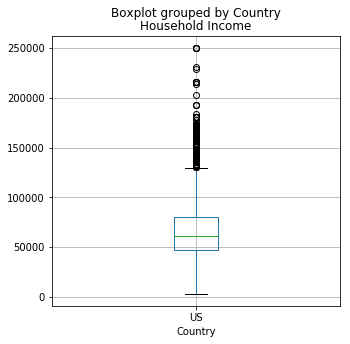

In [22]:
#Box plot for Household Income
SB_HHI_df.boxplot(column='Household Income', by='Country', figsize = (5,5))

35435.6777665133 17505.876261913785


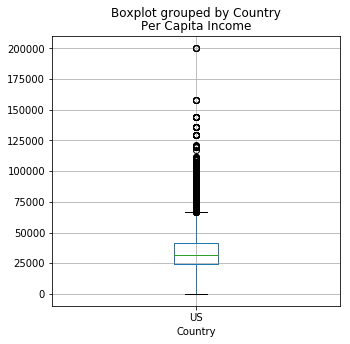

In [24]:
#Get Per capita Income greater than 0
per_capita_df = data_df.loc[ (data_df['Per Capita Income'] > 0 ) & (data_df["Brand"] == "Starbucks"),: ]

# Get the mean and Standard deviation for Per Capita Income
pci_mean = per_capita_df['Per Capita Income'].mean()
pci_std = per_capita_df['Per Capita Income'].std()

#Box plot for Per Capita Income
per_capita_df.boxplot(column='Per Capita Income', by='Country', figsize = (5,5))

print( pci_mean , pci_std)

In [25]:
# Find the Percentage of population that is employed & create new dataframe for Starbucks with census info
data_df['Employment_PCT'] = ''
data_df['Employment_PCT'] = data_df['Employment Labor Force'] * 100 / data_df['Population']
empl_data_df = data_df[pd.notnull(data_df['Store Number'])  & data_df['Employment Labor Force'] > 0 ]

In [26]:
# Get the mean and Standard deviation for Employment Percentage
empl_mean = empl_data_df['Employment_PCT'].mean()
empl_sd = empl_data_df['Employment_PCT'].std()
print(empl_mean, empl_sd)

53.74278323055918 7.6653268515194535


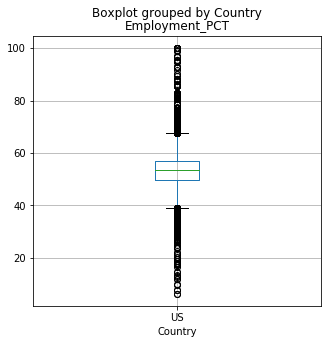

In [27]:
#Box plot for Employment Percentage
empl_data_df.boxplot(column='Employment_PCT', by='Country', figsize = (5,5))

In [28]:
#Add a new column - Recommended & populate it to 'Y' if Census attributes are withn one SD of mean
data_df['Recommended'] = 'N'

for index , row in data_df.iterrows():
    if ( (row['Employment_PCT'] > (empl_mean - empl_sd))  &  \
         (row['Median Age']     > (mean_age - std_mean_age)) &  \
         (row['Median Age']     < (mean_age + std_mean_age))& \
         (row['Household Income'] > (hhi_mean - hhi_std)) & \
         (row['Household Income'] < (hhi_mean + hhi_std)) & \
         (row['Per Capita Income'] > (pci_mean - pci_std)) & \
         (row['Per Capita Income'] < (pci_mean + pci_std)) & \
         (str(row['Store Number']) == 'nan')): \
        data_df.loc[data_df['Zipcode'] == row['Zipcode'], 'Recommended'] = 'Y'    

In [29]:
#Number of records that are Recommended
data_df['Recommended'].value_counts()

N    33308
Y     7957
Name: Recommended, dtype: int64

In [30]:
#Create a dataframe with recommended set 
rec_df = data_df.loc[data_df['Recommended'] == 'Y']

In [31]:
#Create a list with all zipcodes with 2 miles of Starbucks zipcode.
zcdb = ZipCodeDatabase()
rec_l = []

for zipcode in str_df_us.Zipcode:
    try:
        rec_l.append([z.zip for z in zcdb.get_zipcodes_around_radius(zipcode, 2)])
    except:
        print("Error")    

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Erro

In [32]:
#flatten the list
flat_list_str = [item for sublist in rec_l for item in sublist]

In [33]:
#Add a new column 'Another Store Present' and populate to 1 if there is a store within 2 miles
rec_df['Another_Store_Present'] = rec_df.Zipcode.isin(flat_list_str).astype(int)

C:\Users\rz0001\AppData\Local\Continuum\anaconda3\envs\Pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
#Final recommended count of Zipcodes
rec_df['Another_Store_Present'].value_counts()

0    7464
1     493
Name: Another_Store_Present, dtype: int64

In [37]:
#Create final recommendation dataframe
locations_rec = rec_df.loc[rec_df['Another_Store_Present'] == 0]
locations_rec.to_csv('./Resources/Recommended_Zipcodes.csv')

In [38]:
zip_ll_file = os.path.join('Resources' , 'Zip_Lat_Long.txt')
zip_ll_df = pd.read_csv(zip_ll_file)
zip_ll_df.head()

,Zipcode,Lat,Lng
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [39]:
rec_zip_df = pd.DataFrame(locations_rec['Zipcode'].astype(int))
rec_locations_ll = rec_zip_df.merge(zip_ll_df, how='inner', on=['Zipcode'])

In [151]:
#Get lat, long of final recommendations
rec_locations_ll_df = rec_locations_ll[["Lat", "Lng"]].astype(float)

#Plot the lat long on Google map
fig = gmaps.figure()

try:
    starbucks_layer2 = gmaps.symbol_layer(rec_locations_ll_df, fill_color='red', stroke_color='red', scale=1)
except :
    print("Bad Lat Long")
    
fig.add_layer(starbucks_layer2)
fig

Figure(layout=FigureLayout(height='420px'))

In [68]:
state_zip_file = os.path.join("Resources" , "zip_to_state.csv")
state_zip_df = pd.read_csv(state_zip_file)
state_zip_df.head()

,Zipcode,CITY,STATENAME
0,501,Holtsville,NY
1,544,Holtsville,NY
2,601,Adjuntas,PR
3,602,Aguada,PR
4,603,Aguadilla,PR


In [69]:
rec_zip_df = pd.DataFrame(locations_rec['Zipcode'].astype(int))
rec_locations_ll = rec_zip_df.merge(state_zip_df, how='inner', on=['Zipcode'])
rec_locations_gr = rec_locations_ll.groupby('STATENAME')['Zipcode'].count()

In [70]:
final_df = pd.DataFrame({"Recommded_Count" : rec_locations_gr , "Existing_Count" : str_grp_cnt})

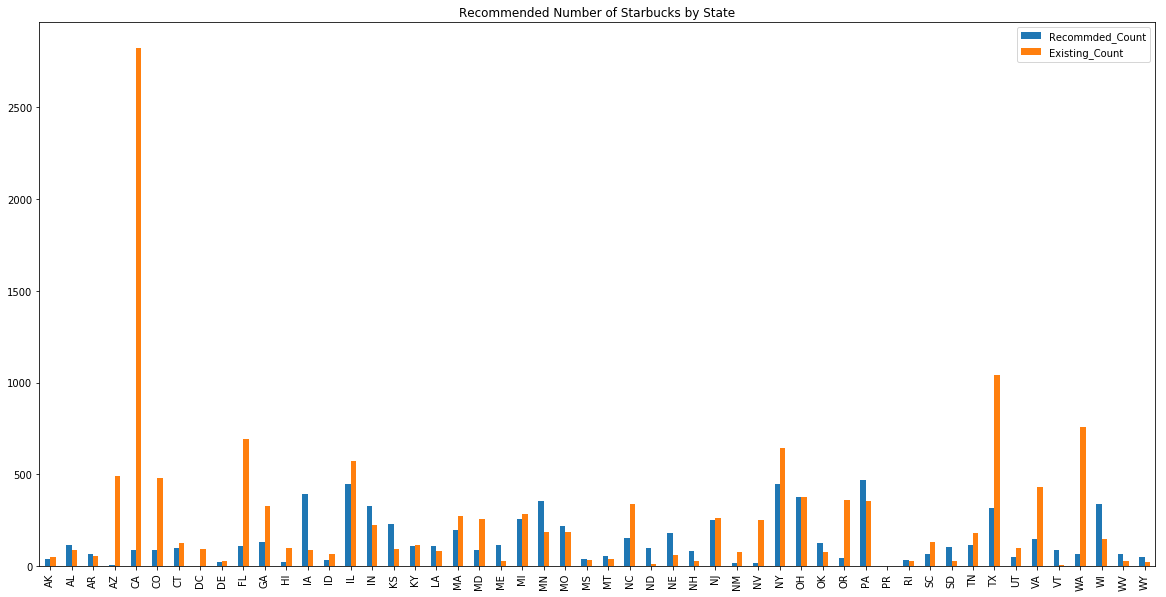

In [74]:
final_df.plot(kind="bar", title = "Recommended Number of Starbucks by State", figsize = (20,10))


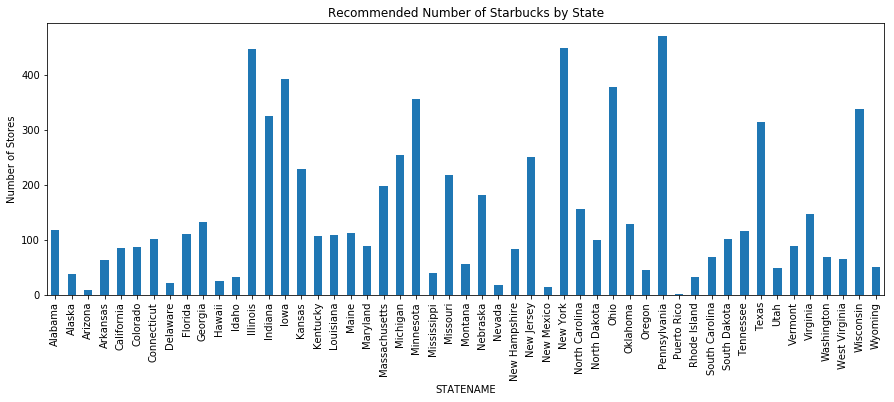

In [56]:
#Bar chart of Recommeded Number of Stores by State
rec_locations_gr.plot(kind="bar", title = "Recommended Number of Starbucks by State", figsize = (15,5))
plt.ylabel("Number of Stores")
plt.savefig('Recommeded_Stores_By_State_Count')

In [103]:
#Independant Tetsing for Household Income
data_df_sb = data_df.loc[ (data_df['Brand'] == 'Starbucks')  &  (data_df['Household Income'] > 0) ]
data_df_sb.rename(columns={'Household Income':'Household_Income'}, inplace=True)
data_df_sb['Household_Income'].mean()

65912.27100675357

In [104]:
data_df_nonsb = data_df.loc[ (data_df['Brand'] != 'Starbucks')  & (data_df['Household Income'] > 0) ]
data_df_nonsb.rename(columns={'Household Income':'Household_Income'}, inplace=True)
data_df_nonsb['Household_Income'].mean()

49831.61869341448

In [101]:
# Calculate Independent (Two Sample) T-Test
stats.ttest_ind(data_df_sb.Household_Income, data_df_nonsb.Household_Income, equal_var=False)

Ttest_indResult(statistic=61.37455871570821, pvalue=0.0)